# Lab4. Amazon Kinesis Data Analytics RCF

This notebook shows how to compute an anomaly score using [RANDOM_CUT_FOREST_WITH_EXPLANATION](https://docs.aws.amazon.com/kinesisanalytics/latest/sqlref/sqlrf-random-cut-forest-with-explanation.html) in Amazon Kinesis Data Analytics for each record in clickstreams. After creating Kinesis Data streams for source and destination streams, Amazon Kinesis Data Analytics will detect anomalies in the input data stream. Records which are distant from other records will have higher anomaly score. The algorithm starts developing the machine learning model using current records in the stream when you start the Kinesis application. The algorithm does not use older records in the stream for machine learning, nor does it use statistics from previous executions of the application.

## Table Of Contents
The overall process for this is:

1. Setup
1. Creating Kineais streams  
    2-1. Createing Kinesis data streams  
    2-2. Creating IAM Role  
    2-3. Creating the Kinesis Data Analytics Application  
    2-4. Starting the Kinesis Data Analytics Application  
1. Sending Input streams  
    3-1. Data preparation  
    3-2. Sending data
1. Plotting the Prediction
1. Stopping and Deleting the Kinesis Data Analytics Application
1. (Optional) Comparison by timedecay parameter

To get started, simply execute all cells below:

## 1. Setup

This notebook code was tested with SageMaker SDK 1.72

In [1]:
# !pip install sagemaker==2.20

Install AWS Data Wrangler. AWS Data Wrangler will put the anomaly detection results to Amazon S3 while running Amazon Kinesis Data Analytics.

In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install awswrangler

In [3]:
import json
import random
import boto3
import os
import time
import numpy as np
import pandas as pd
import awswrangler as wr
from util import *

import matplotlib.pyplot as plt

%matplotlib inline 

In [4]:
kinesis_client = boto3.client('kinesis')
kinesis_analytics = boto3.client('kinesisanalytics')

sess = boto3.Session()

# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 's3://sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)


#### Clickstreamd dataset

Unzip the compressed file and look at the dataset.

In [5]:
data_dir='data'
# !gzip -d $data_dir/*.gz
!tar -zxvf $data_dir/data.tar.gz

data/
data/fault_label_1T.csv
data/clicks_1T.csv
data/clicks.csv
data/.ipynb_checkpoints/
data/clicks_10T.csv
data/fault_label_10T.csv


We will use clickstream dataset resampled by 1 minute. And, like 1st Lab, add the residual of clicks and users as a feature.

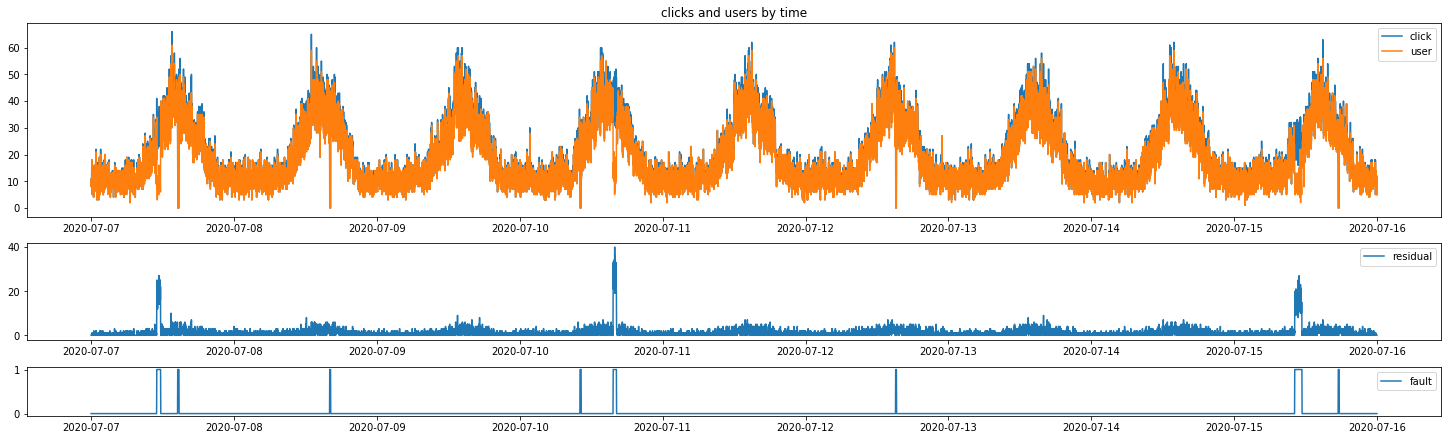

In [6]:
clicks_1T = pd.read_csv(data_dir + '/clicks_1T.csv', parse_dates=['timestamp']).set_index('timestamp')
clicks_1T['residual'] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T['fault'] = pd.read_csv(data_dir + '/fault_label_1T.csv', header=None).values[0]

plot_click_w_fault_and_res(clicks_1T)

# plt.figure(figsize=(30,2))
# plt.plot(clicks_1T['residual'])
# plt.title('residual (click-user) by 1 minute')
# plt.show() 

## 2. Creating Kinesis streams

We need to create below Kinesis resources. 
- 2 Kinesis Data Streams : `clickstream_input`, `clickstream_output`
- 1 Kinesis Analytics Application : `Clickstream-analytics-rcf-explanation`

![](imgs/architecture.png)

Since we use boto3 SDK to create all aws resource we use, you don't need to visit AWS console in this lab. But you may check the status or results in the console intermitantly during the process.


### 2-1. Create Kinesis data streams

First, we create 2 Kinesis data streams that serves as a short term streaming store for clickstreams. The throughput of an Amazon Kinesis data stream is determined by the number of shards within the data stream. We will use 1 for this example. You can calculate the initial number of shards (number_of_shards) the data stream needs using the following formula:
```
 number_of_shards = max (incoming_write_bandwidth_in_KB/1000, outgoing_read_bandwidth_in_KB/2000)
```


In [7]:
data_stream = ['clickstream_input', 'clickstream_output']

try:
    for stream in data_stream:
        kinesis_client.create_stream(
            StreamName=stream,
            ShardCount=1
        )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

# Wait until all streams are created
result = {}
waiter = kinesis_client.get_waiter('stream_exists')
for stream in data_stream:
    waiter.wait(StreamName=stream)
    response = kinesis_client.describe_stream(StreamName=stream)
    result[stream] = response["StreamDescription"]["StreamARN"]

Stream clickstream_input under account 308961792850 already exists.


#### Checking result in the console(Optional)
After the execution, you can find two Kinesis Data streams in the console:
- Amazon Kinesis > Data streams
![](imgs/Kstream-console.png)

### 2-2. Creating IAM Role

In this step, we create an IAM role and add an policy that we will use in the Kinesis to read inputstream and write outputstream.

In [8]:
from botocore.exceptions import ClientError

region = boto3.Session().region_name
iam = boto3.client('iam')
sts = boto3.client('sts')

kinesis_role_name = 'kinesis-analytics-{}'.format(region)
kinesis_analytics_policy_name=kinesis_role_name + '_policy'

kinesis_assume_role={
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "kinesisanalytics.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

try:
    role_res = iam.create_role(
        Path='/service-role/',
        RoleName=kinesis_role_name,
        AssumeRolePolicyDocument=json.dumps(kinesis_assume_role),
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        role_res = iam.get_role(
            RoleName=kinesis_role_name
        )
        print("Role already exists")
    else:
        print("Unexpected error: %s" % e)

Role already exists


In [9]:
kinesis_analytics_policy = {
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "ReadInputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:GetShardIterator",
        "kinesis:GetRecords"
      ],
      "Resource": [
        result['clickstream_input']
      ]
    },
    {
      "Sid": "WriteOutputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:PutRecord",
        "kinesis:PutRecords"
      ],
      "Resource": [
        result['clickstream_output']
      ]
    }
  ]
}
try:
    policy_res = iam.create_policy(
        PolicyName=kinesis_analytics_policy_name,
        Path='/',
        PolicyDocument=json.dumps(kinesis_analytics_policy)
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        PolicyArn ='arn:aws:iam::{}:policy/{}'.format(account_id, kinesis_analytics_policy_name)
        policy_res = iam.get_policy(
            PolicyArn=PolicyArn
        )
        print("Policy already exists")
    else:
        print("Unexpected error: %s" % e)

try:
    attach_res = iam.attach_role_policy(
        PolicyArn=policy_res['Policy']['Arn'],
        RoleName=kinesis_role_name
    )
    print("Policy has been succesfully attached to role: %s" % kinesis_role_name)
except Exception as e:
    print("Unexpected error: %s" % e)

Policy already exists
Policy has been succesfully attached to role: kinesis-analytics-us-east-1


### 2-3. Creating the Kinesis Data Analytics Application


We will configure Kinesis Data Analytics application to process the Kinesis data stream we created as the streaming source. You can add SQL and the destination stream in Kinesis Analytics with the code below. The parameters of the RANDOM_CUT_FOREST_WITH_EXPLANATION function are defined as numberOfTrees, subSampleSize, timeDecay, shingleSize, and withDirectionality.

* **numberOfTrees** : is the number of random cut trees in the forest. 
* **subSampleSize** : is the size of the random sample that you want the algorithm to use when constructing each tree
* **timeDecay** : decides how much of the recent past to consider when computing an anomaly score
* **shingleSize** : is the size of the consecutive sequence of the most recent records. For example, a shingleSize of 10 at time t corresponds to a vector of the last 10 records received up to and including time t. The algorithm treats this sequence as a vector over the last shingleSize number of records. If you set the shingleSize too small, the algorithm is more susceptible to minor fluctuations in the data, leading to high anomaly scores for records that are not anomalous.
If you set the shingleSize too large, it might take more time to detect anomalous records because there are more records in the shingle that are not anomalous. It also might take more time to determine that the anomaly has ended.
![](imgs/shingling_resize.png)
* **withDirectionality** : When set to true, it tells you the direction in which each individual dimension makes a contribution to the anomaly score. It also provides the strength of the recommendation for that directionality.

In this sample code, we set timeDecay as 4,320 (=60x24x3) which means we will take previous 3 days events into consideration. 

In [10]:
%%writefile random_cut_forest_with_explanation.sql

-- ** Anomaly detection **
-- Compute an anomaly score for each record in the source stream using Random Cut Forest
-- Creates a temporary stream and defines a schema
                                
CREATE OR REPLACE STREAM "TEMP_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "RESIDUALS"           INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));
-- Creates an output stream and defines a schema
CREATE OR REPLACE STREAM "DESTINATION_SQL_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "RESIDUALS"           INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));


-- RANDOM_CUT_FOREST anomaly score is a number between 0 and LOG2(subSampleSize)
-- See RANDOM_CUT_FOREST anomaly score explanation https://forums.aws.amazon.com/message.jspa?messageID=751928
-- Normalize the "ANOMALY_SCORE" by dividing it by LOG2(subSampleSize)
--   "shingleSize": 4, 24, 48
--    "numberOfTrees" : 100, 200

CREATE OR REPLACE PUMP "STREAM_PUMP" AS INSERT INTO "TEMP_STREAM"
SELECT STREAM "TIMESTAMPS", "URLS", "USERS", "CLICKS", "RESIDUALS", "ANOMALY_SCORE", "ANOMALY_EXPLANATION" FROM
  TABLE(RANDOM_CUT_FOREST_WITH_EXPLANATION(
    CURSOR(SELECT STREAM * FROM "SOURCE_SQL_STREAM_001"), -- inputStream
    100, -- numberOfTrees
    256, -- subSampleSize
    4320, -- timeDecay (60m x 24h x 3d) (default 100000)
    1, -- shingleSize
    true
  )
);

CREATE OR REPLACE PUMP "OUTPUT_PUMP" AS INSERT INTO "DESTINATION_SQL_STREAM"
SELECT STREAM * FROM "TEMP_STREAM"
ORDER BY FLOOR("TEMP_STREAM".ROWTIME TO SECOND), ANOMALY_SCORE DESC;

Overwriting random_cut_forest_with_explanation.sql


In [11]:
sql_query = open('random_cut_forest_with_explanation.sql', "r").read()
kinesis_ApplicationName='clickstream-analytics-rcf-explanation-{}'.format(int(time.time()))

try:
    response = kinesis_analytics.create_application(
        ApplicationName=kinesis_ApplicationName,
        ApplicationCode=sql_query,
        Inputs=[
            {
                'NamePrefix': 'SOURCE_SQL_STREAM',
                'KinesisStreamsInput': {
                    'ResourceARN': result[data_stream[0]],
                    'RoleARN': role_res['Role']['Arn']
                },
                'InputSchema': {
                    'RecordFormat': {
                        'RecordFormatType': 'JSON',
                        'MappingParameters': {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        }
                    },
                    'RecordEncoding': 'UTF-8',
                    'RecordColumns': [
                                {
                                    "SqlType": "TIMESTAMP",
                                    "Name": "TIMESTAMPS",
                                    "Mapping": "$.timestamp"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "URLS",
                                    "Mapping": "$.page"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "USERS",
                                    "Mapping": "$.user"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "CLICKS",
                                    "Mapping": "$.click"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "RESIDUALS",
                                    "Mapping": "$.residual"
                                }
                    ],
                    "RecordFormat": {
                        "MappingParameters": {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        },
                        "RecordFormatType": "JSON"
                      }
                }
            },
        ],
        Outputs=[
            {
                'Name': 'DESTINATION_SQL_STREAM',
                'DestinationSchema': {
                    'RecordFormatType': 'JSON'
                },
                "KinesisStreamsOutput": {
                    "ResourceARN": result[data_stream[1]],
                    "RoleARN": role_res['Role']['Arn']
                }
            },
        ],
    )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e)

#### Checking result in the console(Optional)
After the execution, you can find Kinesis Analytics Application (in ready status) in the console:
- Amazon Kinesis > Analytics Applciation
![](imgs/Kapplication-ready.png)

### 2-4. Starting the Kinesis Data Analytics Application

Start the Amazon Kinesis Analytics application. After the application starts, it begins consuming the input data, processes it, and writes the output to the configured destination.

In [12]:
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)

application = response["ApplicationDetail"]
inputId = application['InputDescriptions'][0]['InputId']

try:
    kinesis_analytics.start_application(ApplicationName=kinesis_ApplicationName,
                                     InputConfigurations=[{
                                       "Id": inputId,
                                       "InputStartingPositionConfiguration": {
                                         "InputStartingPosition": "NOW"
                                       }
                                     }])
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

In [13]:
# Wait until application starts running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write('Starting ')
while status != "RUNNING":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
      ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('RUNNING')
sys.stdout.write(os.linesep)

Starting .................................................................................................RUNNING


#### Checking result in the console(Optional)
After the execution, you can find Kinesis Analytics Application (in running status) in the console:
- Amazon Kinesis > Analytics Applciation
![](imgs/Kapplication-running.png)

## 3. Sending Input streams

### 3-1. Data Preparation
We use aggagated timeseries as input data, which have 4 features of the number of visited sites, the number of visitors, the numbor of clicks, and residuals of clicks and users in 1 minute.

In [14]:
clicks_1T_wt = clicks_1T.drop(['fault'],axis=1).reset_index()
col_names = clicks_1T_wt.keys().to_list()

# This function trasnforms input dfatafram to Kinesis put_record json
def make_kinesis_data(df, i, col_names):
    kinesis_data = {}
    kinesis_data['timestamp']=str(df['timestamp'][i])
    for col_name in col_names:
        if col_name not in ['timestamp']:
            kinesis_data[col_name]=int(df.iloc[i][col_name])
    return kinesis_data

# test
# make_kinesis_data(clicks_1T_wt, 0, col_names)

In [15]:
# This function saves the results from Kinesis Analytics into the S3
def s3_sink(shardIterator):
    rows = []
    response = kinesis_client.get_records(ShardIterator=shardIterator)
    records = response["Records"]

    try:
        while len(records) > 0:
            parsed_records = []
            for rec in records:
                parsed_record = json.loads(rec["Data"])
                parsed_records.append(parsed_record)
            rows.extend(parsed_records)
            time.sleep(1)
            shardIterator = response["NextShardIterator"]
            response = kinesis_client.get_records(ShardIterator=shardIterator)
            records = response["Records"]
        flag = rows[0]['TIMESTAMPS'].replace(":","-").replace(" ","-").replace(".","-")
        s3_save_path = '{}/{}/{}'.format(job_bucket, 'kinesis-analytics', flag)
        wr.s3.to_csv(
            df=pd.DataFrame(rows),
            path=s3_save_path
        )
    except:
        sys.stdout.write("[ExpiredIteratorException] Iterator expired.")
        pass
    return rows

### 3-2. Sending data


<!-- Similar to streaming data in real-time, we put clickstreams into Kinesis Data Analytics through Kinesis Data Stream by one record using For statement. Anomaly scores and explanations will be added to clickstreams through Kinesis analytics. -->
Now let's send the data to the Kiensis input data stream.  

By executing below code, you will:  

1) Send clickstream data into Kinesis data stream (`clickstream_input`).    
2) Write the anomaly score of output stream(`clickstream_output`) in the S3.  
3) Append the anomaly score to the `result` list to check the result.  

We used the APIs in Kinesis:
- [put_record](https://docs.aws.amazon.com/kinesis/latest/APIReference/API_PutRecord.html) - in following cell (inside the `for` loop)
- [get_records](https://docs.aws.amazon.com/kinesis/latest/APIReference/API_GetRecords.html) - in previous cell (s3_sink() function)

You can refer to the [Kinesis developer guide](https://docs.aws.amazon.com/streams/latest/dev/building-producers.html) for more information.

Running next cell takes 3~ 5 minutes. 

**NOTE** - _Please note that we send entire clickstream dataset at once. If it were real production environment, we need to wait whole 9 days to see the results. Instead, since the purpose of this lab is to see the Kinesis RCF function, we will send all streams at once by just repeating put_record() function for all dataset records._

In [16]:
%%time
response = kinesis_client.describe_stream(StreamName=data_stream[1])
shardId = response["StreamDescription"]["Shards"][0]["ShardId"]
shard_response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
shardIterator = shard_response["ShardIterator"]

scores = []
rnd=random.random()

for idx in clicks_1T_wt.index:
    kinesis_data = json.dumps(make_kinesis_data(clicks_1T_wt, idx, col_names))
    kinesis_client.put_record(
        StreamName=data_stream[0],
        Data=kinesis_data,
        PartitionKey=str(rnd)
    )
# time.sleep(3)
scores.extend(s3_sink(shardIterator))

[ExpiredIteratorException] Iterator expired.CPU times: user 34.2 s, sys: 469 ms, total: 34.7 s
Wall time: 2min 1s


Exception ignored in: <bound method _S3Object.__del__ of <awswrangler.s3._fs._S3Object object at 0x7f4023846080>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awswrangler/s3/_fs.py", line 257, in __del__
    self.close()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awswrangler/s3/_fs.py", line 540, in close
    function_name="put_object", s3_additional_kwargs=self._s3_additional_kwargs
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awswrangler/_utils.py", line 294, in try_it
    return f(**kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 357, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 676, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.NoSu

#### Checking result in the console(Optional) 

While waiting the result, you may check the AWS console and watch Kinesis Analytics calcualting Anomaly score libe below screen

- Checking input stream - You can monitor the raw clickstream that we sent.
![](imgs/Kapp-mon1-resize.png) 

- Checking transformed stream - You can see the anomaly score as well as raw clickstreams
![](imgs/Kapp-mon2-resize.png)


Now we have output stream results with ANOMALY_SCORE. Convert this result in json format to data frame. 

In [17]:
from datetime import datetime

# parse the result scores(json) to dataframe
def scores_to_df(scores):
    revised_result = []
    for row in scores:
        result_row = {}
        result_row['timestamp'] = datetime.strptime(row['TIMESTAMPS'].split('.')[0],'%Y-%m-%d %H:%M:%S')
        result_row['page'] = row['URLS']
        result_row['user'] = row['USERS']
        result_row['click'] = row['CLICKS']
        result_row['residual'] = row['RESIDUALS']
        result_row['ANOMALY_SCORE'] = row['ANOMALY_SCORE']

        anomaly_exp = json.loads(row['ANOMALY_EXPLANATION'])
        result_row['URLS_STRENGTH'] = float(anomaly_exp['URLS']['STRENGTH'])
        result_row['URLS_ATTRIBUTION_SCORE'] = float(anomaly_exp['URLS']['STRENGTH'])
        result_row['USERS_STRENGTH'] = float(anomaly_exp['USERS']['STRENGTH'])
        result_row['USERS_ATTRIBUTION_SCORE'] = float(anomaly_exp['USERS']['ATTRIBUTION_SCORE'])
        result_row['CLICKS_STRENGTH'] = float(anomaly_exp['CLICKS']['STRENGTH'])
        result_row['CLICKS_ATTRIBUTION_SCORE'] = float(anomaly_exp['CLICKS']['ATTRIBUTION_SCORE'])
        result_row['RESIDUALS_STRENGTH'] = float(anomaly_exp['RESIDUALS']['STRENGTH'])
        result_row['RESIDUALS_ATTRIBUTION_SCORE'] = float(anomaly_exp['RESIDUALS']['ATTRIBUTION_SCORE'])
        revised_result.append(result_row)
    return pd.DataFrame(revised_result)

result_data = scores_to_df(scores)
result_data = result_data.sort_values(by=['timestamp']).set_index('timestamp')
result_data['fault'] = list(clicks_1T['fault'])

high_anomaly=result_data
high_anomaly.sort_values(by=['ANOMALY_SCORE'], ascending=False).head(5)

,page,user,click,residual,ANOMALY_SCORE,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE,RESIDUALS_STRENGTH,RESIDUALS_ATTRIBUTION_SCORE,fault
timestamp,,,,,,,,,,,,,,
2020-07-07 11:03:00,12,11,36,25,4.006523,0.0031,0.0031,0.2007,0.4114,0.4905,0.7489,8.0835,2.7385,1
2020-07-07 10:28:00,10,34,35,1,3.899363,0.0001,0.0001,2.0019,1.9333,1.9901,1.9325,0.0000,0.0063,0
2020-07-07 11:01:00,10,34,41,7,3.780544,0.0000,0.0000,0.2274,0.7067,2.8342,2.0965,0.3545,0.9684,1
2020-07-07 13:35:00,13,61,66,5,3.594213,0.0015,0.0015,2.5771,1.5829,3.6058,1.7954,0.0036,0.1436,0
2020-07-07 09:05:00,10,27,28,1,3.559661,0.0089,0.0089,1.1939,1.6894,1.2203,1.6947,0.0000,0.0041,0


The explanation in the result provides the following values for each column in the record:

* **Attribution score** : A nonnegative number that indicates how much this column has contributed to the anomaly score of the record
* **Strength** : A nonnegative number representing the strength of the directional recommendation. 
* **Directionality** : This is either HIGH if the value of the column is above the recently observed trend or LOW if it’s below the trend. During the learning phase, this defaults to LOW.


Check the distribution of our anomaly score.

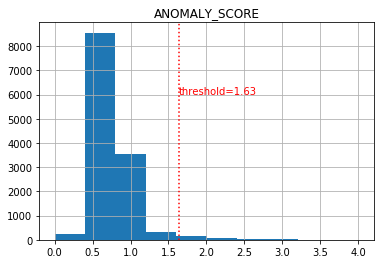

3 sigma threshoud = 1.633597746134067


In [18]:
threshold = result_data['ANOMALY_SCORE'].mean() + 3*result_data['ANOMALY_SCORE'].std()

results_pd = pd.DataFrame(result_data['ANOMALY_SCORE'])
results_pd.hist()
plt.axvline(x=threshold, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold,2)), xy=(threshold,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold))


## 4. Plotting the Prediction

Like we did in the SageMaker RCF Lab, plot the anomalous points detected by Kinesis RCF.

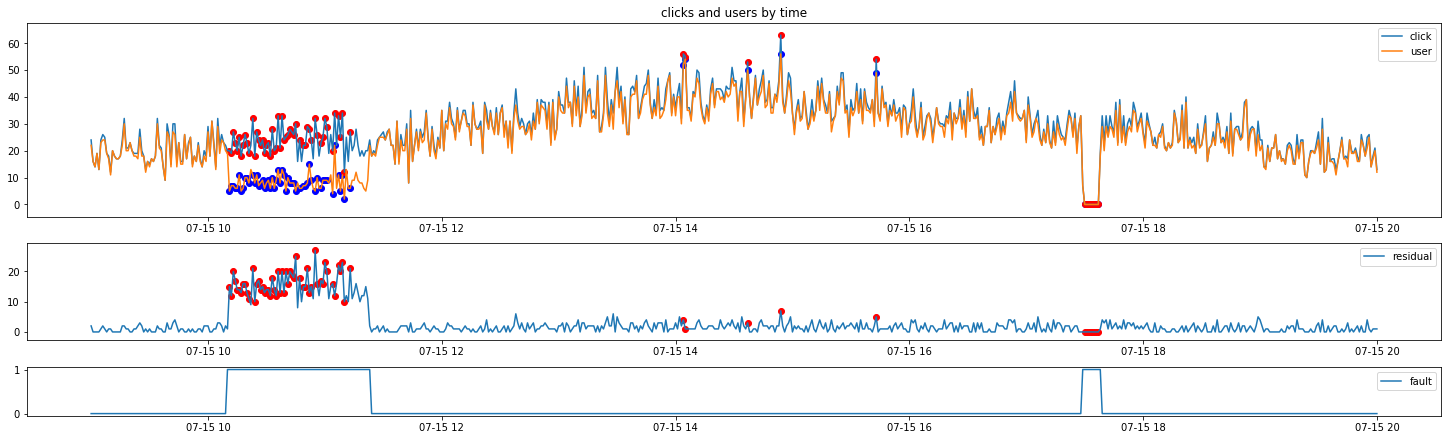

In [19]:
anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"

plot_click_w_fault_res_ad(result_data, anomalous, threshold, start_dt=stime, end_dt=etime)

We can see more anmoalous points that exceed the threshold at the time of a system or program fault event.

Additinally, we have additional colomns which explain contribution of features. Plot the anomaly score and check which values most affected the anomaly score. 

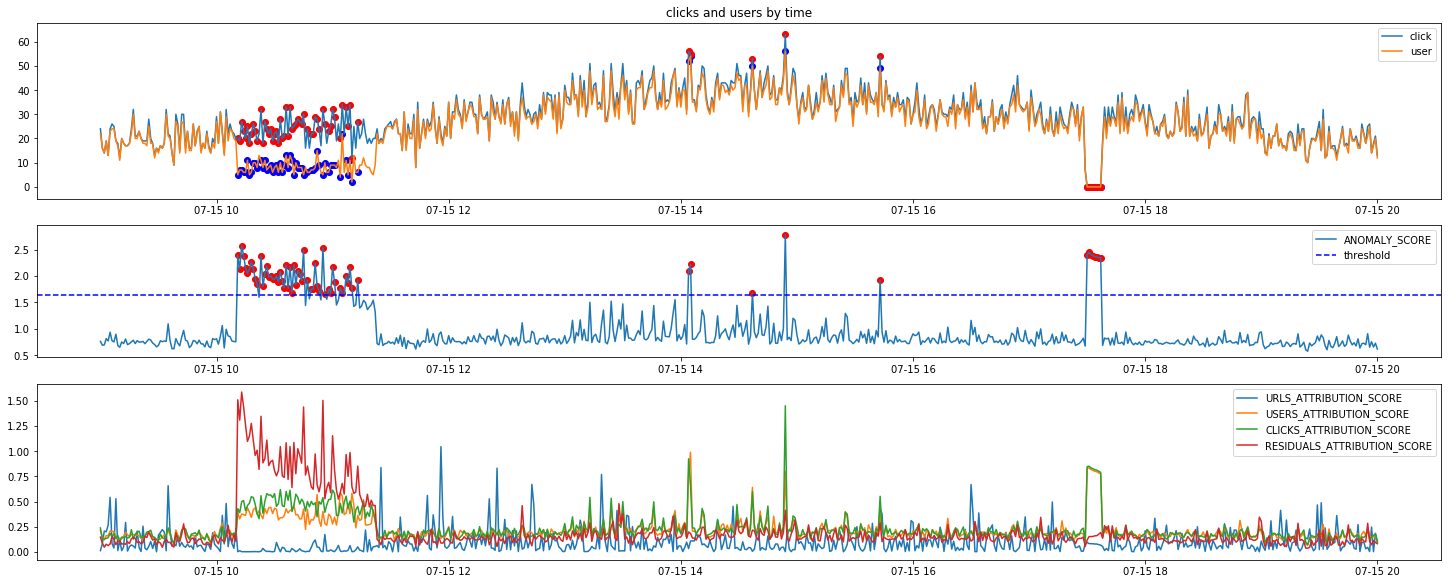

In [20]:
plot_click_w_ad_exp(result_data, anomalous, threshold, start_dt=stime, end_dt=etime)

The graph at the bottom shows the portion to which each column contributed to the anomaly score.  

We can see that the `RESIDUAL` feature explicitly contributed a lot in detecting program fault events (red line around from 10:10 to 11:23).  
On the other hand, the `number of clicks` contributes significantly to detecting system fault events (green line around from 17:29 to 17:38).

## 5. Stopping and Deleting the Kinesis Data Analytics Application

This is the end of the LAB. You can stop and delete the Kinesis Analytics Application using the following code.

In [21]:
kinesis_analytics.stop_application(ApplicationName=kinesis_ApplicationName)

# Wait until application stops running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('Stopping ')

while status != "READY":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
        ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write(os.linesep)

Stopping ....


In [22]:
kinesis_analytics.delete_application(ApplicationName=kinesis_ApplicationName,
                                     CreateTimestamp=response['ApplicationDetail']['CreateTimestamp'])

{'ResponseMetadata': {'RequestId': '62b2bf35-c39a-402e-becd-e12eb788e8d5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '62b2bf35-c39a-402e-becd-e12eb788e8d5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Sun, 03 Jan 2021 12:20:04 GMT'},
  'RetryAttempts': 0}}